## Data Retrieval

In [2]:
# %pip install google-cloud-bigquery
# %pip install db-dtypes
# %pip install google-cloud-bigquery-storage
# %pip install pandas-gbq
# %pip install shap

In [3]:
from pandas_gbq import read_gbq
from google.oauth2 import service_account
import pandas as pd
import numpy as np

In [4]:
#Get df from BigQuery
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For ML Data (Blank Cells filled with Assumptions)
ml_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_ml_data`",
    project_id=proj_id,
    credentials=creds,
)
print(ml_df.head())
#print(ml_df.dtypes)

Downloading: 100%|██████████|
                                                 URL          Brand  \
0  https://carro.co/sg/en/cars/kia/cerato/kia-cer...            Kia   
1  https://carro.co/sg/en/cars/honda/civic/honda-...          Honda   
2  https://www.motorist.sg/used-car/10253/mercede...  Mercedes-Benz   
3  https://www.motorist.sg/used-car/10202/honda-s...          Honda   
4  https://www.motorist.sg/used-car/10197/honda-c...          Honda   

                            Make     Price Registration_Date   Sold  \
0                 Cerato 1.6A EX   93888.0        2020-09-24   True   
1  Civic 1.5A VTEC Turbo Sunroof   83888.0        2017-07-18   True   
2                           280S   59800.0        1978-08-31   True   
3                    S2000 2.2 M  102800.0        2008-09-24   True   
4             CIVIC TYPE-R 2.0 M   99800.0        2009-12-23  False   

   Number_of_Previous_Owners  Mileage_km  Previous_COE      OMV  ...  \
0                          1       46268    

## Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [6]:
# not very useful in predictions, or correlated with other columns
drop_cols = ["URL", "Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date", "Sold"] 
data = ml_df.drop(drop_cols, axis=1)

In [7]:
data["Make3"] = (
    data["Make"]
    .fillna("")
    .astype(str)
    .str.split()
    .str[:3]
    .str.join(" ")
    .str.strip()
    .replace("", np.nan)
)
data = data.drop(columns=["Make"])

In [8]:
X = data.drop(columns='Price')
y = data['Price']

In [9]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [10]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('regressor', RandomForestRegressor(random_state=42))
    ('regressor', RandomForestRegressor(random_state=42,
                                        n_estimators=300,
                                        min_samples_leaf=2,
                                        min_samples_split=5,
                                        max_features=0.8,
                                        max_depth=20,
                                        bootstrap=True)) # params according to finetuning 
])

In [15]:
# param_grid = {
#     'regressor__n_estimators': [100, 200, 300, 500],
#     'regressor__max_depth': [10, 20, 30, None],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 4],
#     'regressor__max_features': ["sqrt", "log2", 0.6, 0.8, 1.0],
#     'regressor__bootstrap': [True, False]
# }

In [16]:
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_iter=25,
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1,
#     scoring='r2'
# )

In [17]:
# random_search.fit(X_train, y_train)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Previous_Owners',
                                                   'Mileage_km', 'Previous_COE',
                                                   'OMV', 'Road_Tax_Payable',
                                                   'Engine_Capacity_cc',
                                                   'Horse_Power_kW',
                                                   'Vehicle_Age_Years',
                                                   'Vehicle_Age_Days',
                                                   'COE_Left_Days',
                                                   'COE_Cycles',
                                                   'Stocks_Monthly_Avg',
                                                   'Quota_Current_COE',
                                                   'Bid...
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Brand', 'Transmission',
                                                   'Fuel_Type', 'COE_Category',
                                                   'COE_Renewed',
                                                   'Five_Year_COE',
                                                   'Classic_Car', 'Website',
                                                   'Make3'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features=0.8,
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=300, random_state=42))])

In [18]:
# print(f"best_params: {random_search.best_params_}")
# print(f"train_cv_r2: {random_search.best_score_}")

In [19]:
# rf_best = random_search.best_estimator_
# rf_best.fit(X_train, y_train)
test_pred = rf.predict(X_test)

In [20]:
r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mape = (abs((y_test - test_pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

R²: 0.9595
MAE: 10764.7083
RMSE: 31048.3265
MAPE: 9.7077%


### Random forest visualization

In [21]:
import matplotlib.pyplot as plt
import shap

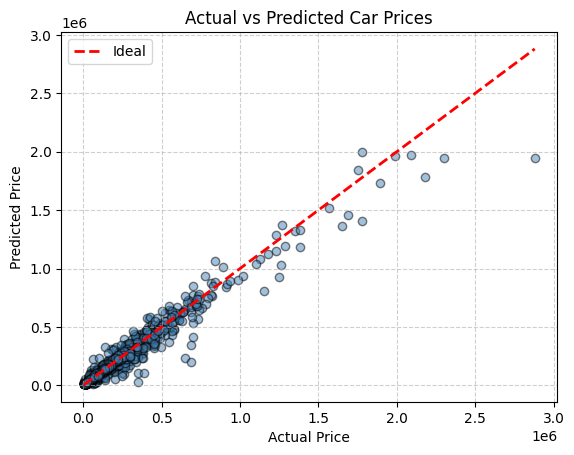

In [22]:
# actual vs predicted
plt.scatter(y_test, test_pred, alpha=0.5, color="steelblue", edgecolors="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--", linewidth=2, label="Ideal")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

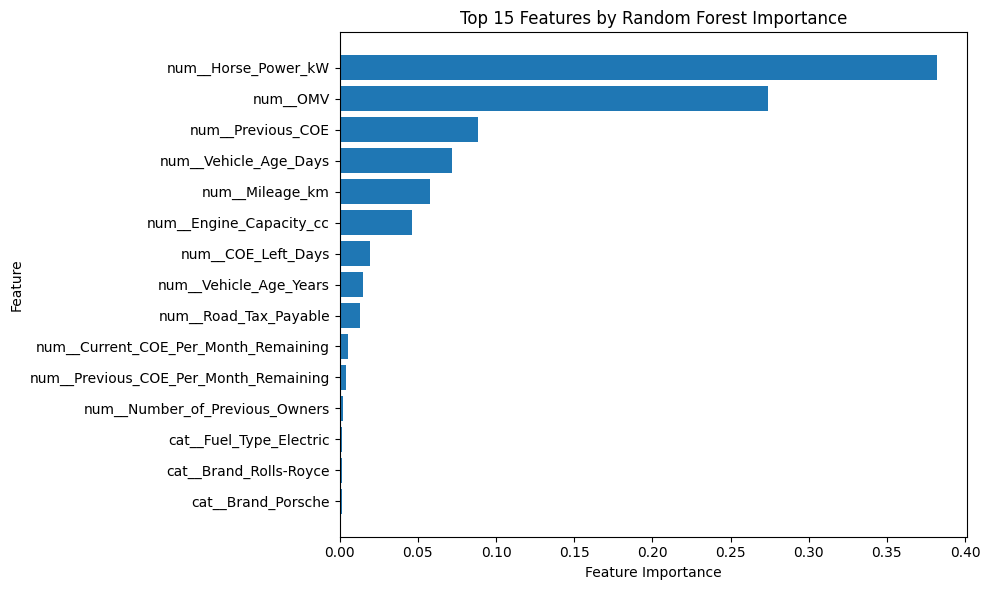

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NUM = 15

# 1) Get feature names produced by your ColumnTransformer
feature_names = rf.named_steps['preprocessor'].get_feature_names_out()

# 2) Get importances from the fitted forest
importances = rf.named_steps['regressor'].feature_importances_

# 3) Put into a DataFrame and sort
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)

# 4) Take top-N for display
top = imp_df.head(NUM).iloc[::-1]  # reverse so largest shows at top of barh

# 5) Plot (single plot, no explicit colors)
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features by Random Forest Importance')
plt.tight_layout()
plt.show()


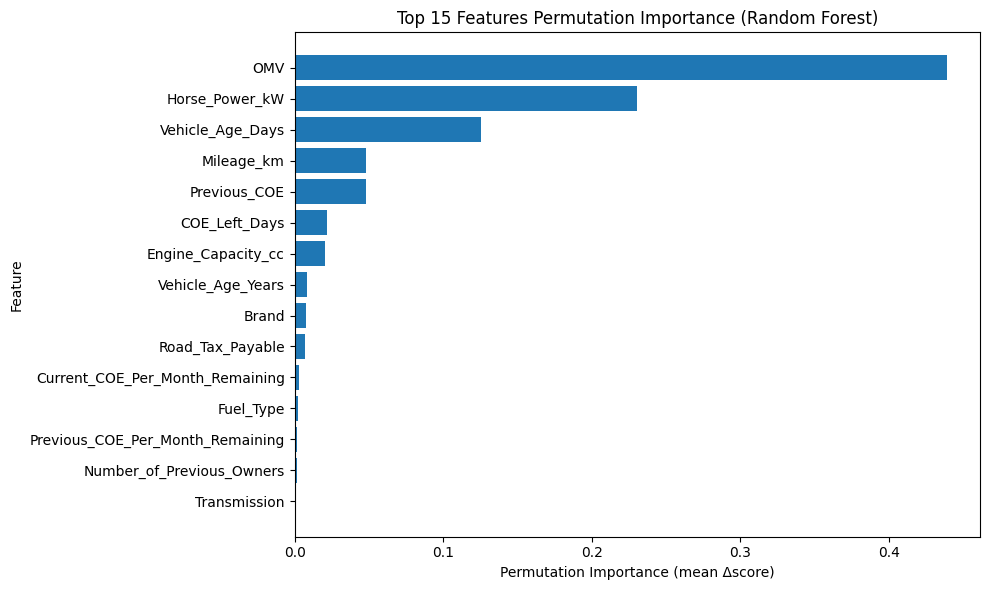

In [27]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

NUM = 15

# Permute inputs to the *pipeline* (raw X_*), measure drop in score
result = permutation_importance(
    rf, X_test, y_test,  # use your validation/holdout set
    n_repeats=10, random_state=42, n_jobs=-1
)

# Names must match X_valid columns (pre-preprocessing)
feature_names = getattr(X_test, 'columns', range(X_test.shape[1]))

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

top = perm_df.head(NUM).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Permutation Importance (mean Δscore)')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features Permutation Importance (Random Forest)')
plt.tight_layout()
plt.show()


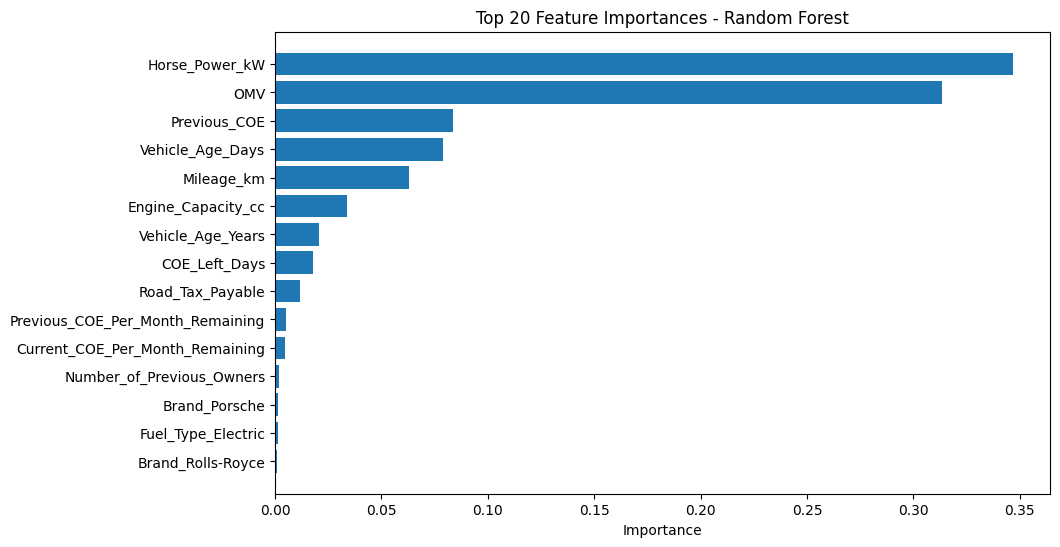

In [ ]:
# top 20 important features
# Extract the trained random forest model
rf_model = rf.named_steps['regressor']

# Get preprocessor and feature names
preprocessor = rf.named_steps['preprocessor']

# Get column names after one-hot encoding
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = np.concatenate([num_features, cat_features])

# Get feature importances
importances = rf_model.feature_importances_

# Create dataframe
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'][:15][::-1], feat_importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

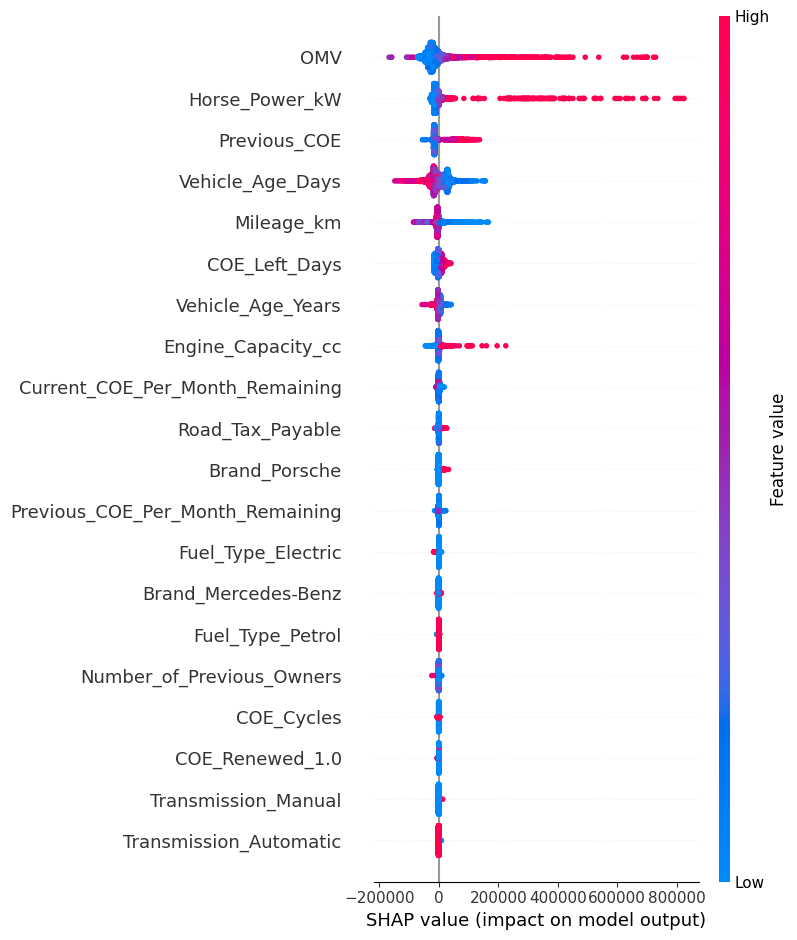

In [ ]:
# Initialize explainer (use only transformed data)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

# Create SHAP summary plot
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

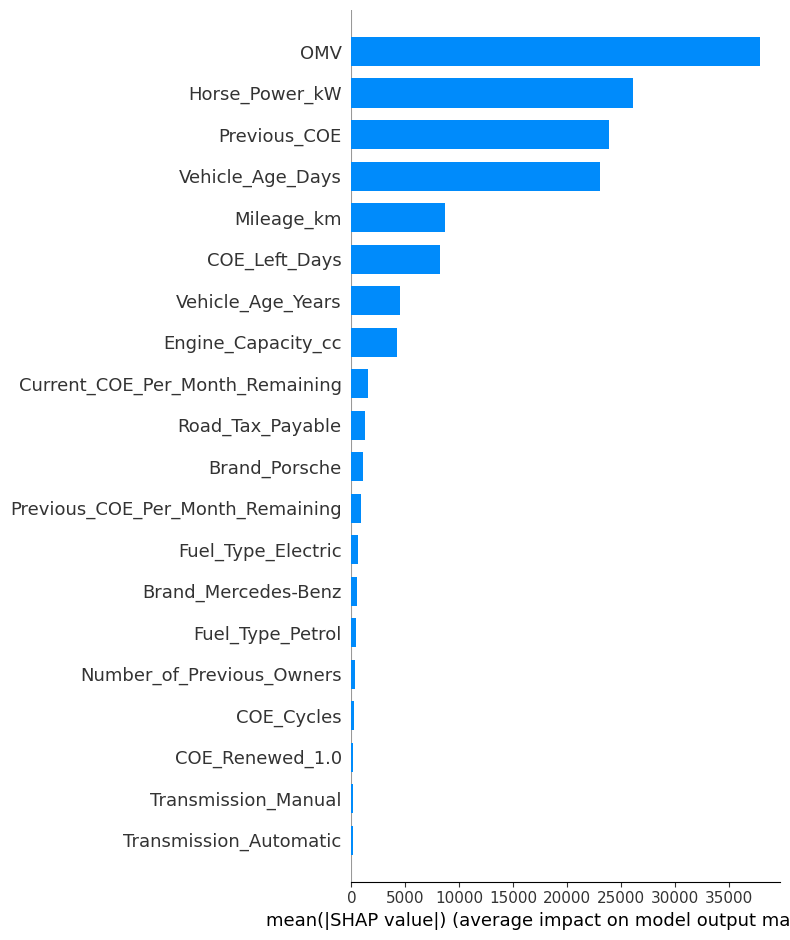

In [ ]:
# shap bar
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type="bar")

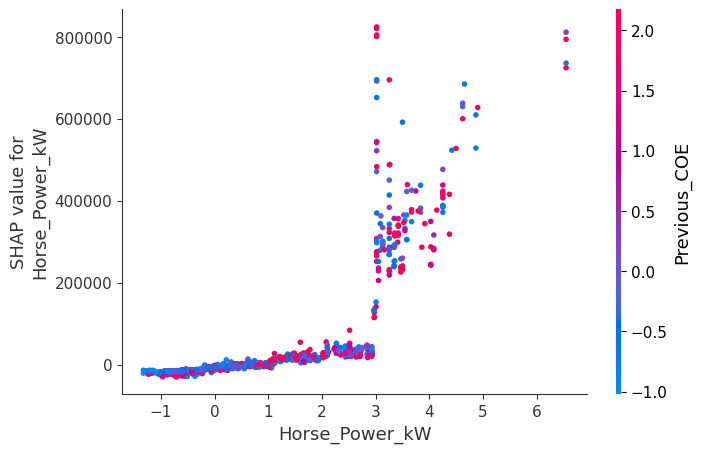

In [ ]:
# Plot dependence of top feature
top_feature = feat_importance_df.iloc[0]['Feature']
shap.dependence_plot(top_feature, shap_values, X_test_transformed, feature_names=feature_names)